In [1]:
from IPython.core.display import HTML
# Create HTML for text with gradient color
html_text = """
<div style='font-size:50px; font-weight:bold; text-align:center; background: linear-gradient(to right, red, orange, yellow, green, blue, indigo, violet); -webkit-background-clip: text; color: transparent;'>
    SVR Approach 3
</div>
"""

# Display the HTML in the output cell
display(HTML(html_text))

In [2]:
import pandas as pd
import numpy as np
from sklearn.svm import SVR
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV, LeaveOneOut
from sklearn.metrics import mean_squared_error
from mlxtend.feature_selection import SequentialFeatureSelector as SFS
from sklearn.model_selection import RandomizedSearchCV
import matplotlib.pyplot as plt
import shap

C:\Users\ayden\.ai-navigator\micromamba\envs\cuda\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


*** Processing SVR with optimal hyperparameters... ***
Best parameters found: {'C': np.float64(1000.0), 'degree': 2, 'epsilon': np.float64(0.01), 'gamma': np.float64(0.01), 'kernel': 'sigmoid'}
*** Processing Sequential Backward Selection... ***
Selected feature indices: [0, 1, 2, 3, 5, 6, 7, 8]
Selected feature names: Index(['IMTP_Peak Vertical Force [N] ', 'Avg_Bicep',
       'LCMJ_Velocity at Peak Power [m/s]', 'Concentric Peak Velocity [m/s]',
       'Sex', 'Height (cm)', 'Weight (kg)', 'Age'],
      dtype='object')
Number of selected features: 8
RMSE with Optimal Features from SBS: 4.6905983726067175


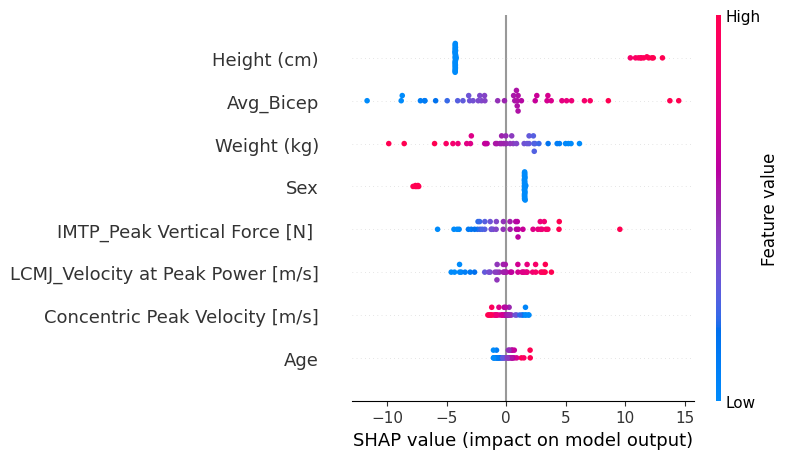

Feature Importance based on SHAP values:
                             Feature  SHAP Value
5                        Height (cm)    6.249181
1                          Avg_Bicep    4.330934
6                        Weight (kg)    2.712217
4                                Sex    2.578484
0      IMTP_Peak Vertical Force [N]     2.381843
2  LCMJ_Velocity at Peak Power [m/s]    1.898149
3     Concentric Peak Velocity [m/s]    0.789724
7                                Age    0.642203
Analysis Complete.


In [4]:
# Define SVR parameter grid for GridSearchCV
param_grid_svr = {
    'C': np.logspace(-4, 4, 9),  # Reduced granularity
    'epsilon': np.logspace(-4, 1, 6),  # Reduced granularity
    'kernel': ['linear', 'poly', 'rbf', 'sigmoid'],
    'degree': [2, 3, 4, 5],  # Reduced the range slightly
    'gamma': ['scale', 'auto'] + list(np.logspace(-4, 1, 6))  # Reduced granularity
}

# Load stage 1 and stage 2 datasets
df_stage1 = pd.read_csv('Training_Set_Gen_Pop_No_MP.csv')  # Load the general population training data for stage 1
df_stage2 = pd.read_csv('Training_Set_Mil_Pop_No_MP.csv')  # Load the military personnel data for stage 2

# Combine both datasets (Stage 1 + Stage 2)
X = pd.concat([df_stage1.drop(['Lift-to-Place'], axis=1), df_stage2.drop(['Lift-to-Place'], axis=1)], axis=0)
y = pd.concat([df_stage1['Lift-to-Place'], df_stage2['Lift-to-Place']], axis=0)

# Standardize the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Initialize Leave-One-Out cross-validator
loo = LeaveOneOut()

# Initialize SVR model
svr = SVR()

# Perform Grid Search CV for hyperparameter tuning
print("*** Processing SVR with optimal hyperparameters... ***")
grid_search_svr = GridSearchCV(svr, param_grid_svr, cv=loo, scoring='neg_mean_squared_error', n_jobs=-1)
grid_search_svr.fit(X_scaled, y)

# Best hyperparameters
best_params_svr = grid_search_svr.best_params_
print("Best parameters found:", best_params_svr)

# Train the SVR model with the best hyperparameters
svr_best = SVR(**best_params_svr)

# Initialise Sequential Feature Selector with backward selection
sfs = SFS(svr_best, 
          k_features=(1, X_scaled.shape[1]),  # Range: from 1 feature to the total number of features
          forward=False,  # Set to False for backward selection
          floating=True,  # Enable floating
          scoring='neg_mean_squared_error', 
          cv=loo,  # Using Leave-One-Out cross-validation
          n_jobs=-1)

# Fit SFS to find the optimal subset of features
print("*** Processing Sequential Backward Selection... ***")
sfs = sfs.fit(X_scaled, y)

# Get the indices of the selected features
selected_indices = list(sfs.k_feature_idx_)
print("Selected feature indices:", selected_indices)

# Get the selected feature names
selected_feature_names = X.columns[selected_indices]
print("Selected feature names:", selected_feature_names)

# Print the number of selected features
print(f"Number of selected features: {len(selected_indices)}")

# Train the model with the selected features
X_optimal_sbs = X_scaled[:, selected_indices]
svr_best.fit(X_optimal_sbs, y)

# Evaluate the model performance
y_pred_optimal_sbs = svr_best.predict(X_optimal_sbs)
rmse_optimal_sbs = np.sqrt(mean_squared_error(y, y_pred_optimal_sbs))
print("RMSE with Optimal Features from SBS:", rmse_optimal_sbs)

### SHAP Analysis to explain feature importance

# Initialize SHAP Explainer
explainer = shap.Explainer(svr_best.predict, X_optimal_sbs)

# Calculate SHAP values for the selected features
shap_values = explainer(X_optimal_sbs)
shap.summary_plot(shap_values, X_optimal_sbs, feature_names=selected_feature_names)

# Calculate the mean absolute SHAP values to understand the average impact of each feature
shap_sum = np.abs(shap_values.values).mean(axis=0)

# Create a DataFrame with feature names and their corresponding SHAP values
feature_importance = pd.DataFrame(list(zip(selected_feature_names, shap_sum)), columns=['Feature', 'SHAP Value'])
feature_importance = feature_importance.sort_values(by='SHAP Value', ascending=False)

print("Feature Importance based on SHAP values:")
print(feature_importance)

# Store results
LOO_SVR_Seq_model_results = {
    'SVR': {
        'RMSE Optimal': rmse_optimal_sbs,
        'Optimal Features': selected_feature_names.tolist(),
        'Selected Feature Indices': selected_indices,  # Store the indices of the selected features
        'Number of Selected Features': len(selected_indices),  # Include the number of selected features
        'Model': svr_best,
        'Feature Importance': feature_importance
    }
}

print("Analysis Complete.")

In [5]:
# Create HTML for text with black color
html_text = """
<div style='font-size:60px; font-weight:bold; text-align:center; color: black;'>
    Optimal features saved to .csv file
</div>
"""

# Display the HTML in the output cell
HTML(html_text)

In [6]:
# Reconstruct the original DataFrame with selected features and target
optimal_features_df = pd.concat([df_stage1, df_stage2])[selected_feature_names.tolist() + ['Lift-to-Place']]

# Save the DataFrame to a CSV file
optimal_features_df.to_csv('SVR_optimal_features_with_target.csv', index=False)
print("Optimal features and target saved to 'SVR_optimal_features_with_target.csv'.")

Optimal features and target saved to 'SVR_optimal_features_with_target.csv'.


In [7]:
# Create HTML for text with black color
html_text = """
<div style='font-size:60px; font-weight:bold; text-align:center; color: black;'>
    Optimise Parameters
</div>
"""

# Display the HTML in the output cell
HTML(html_text)

*** Tuning hyperparameters for SVR (Randomized Search with LOO)... ***
Fitting 41 folds for each of 1000 candidates, totalling 41000 fits
Best parameters found: {'kernel': 'sigmoid', 'gamma': np.float64(0.01), 'epsilon': np.float64(0.0001), 'degree': 2, 'C': np.float64(1000.0)}
Root Mean Squared Error (LOO SVR): 4.692821825802717


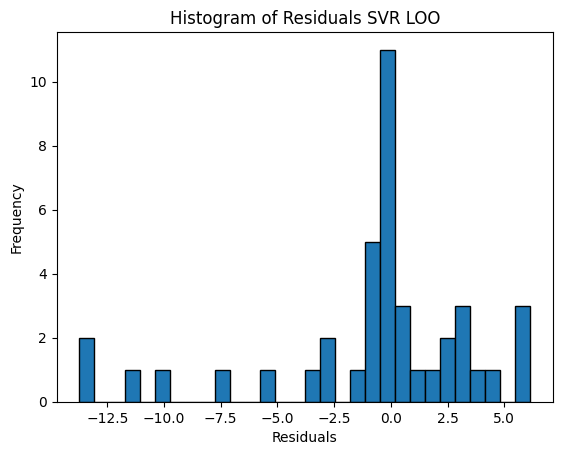

In [8]:
# Load the data
df = pd.read_csv('SVR_optimal_features_with_target.csv')  # Adjust the file name if needed

# Separate features and target variable
X = df.drop(['Lift-to-Place'], axis=1)
y = df['Lift-to-Place']

# Standardize features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Define a parameter grid for SVR
param_grid_svr = {
    'C': np.logspace(-4, 4, 9),
    'epsilon': np.logspace(-4, 1, 6),
    'kernel': ['linear', 'poly', 'rbf', 'sigmoid'],
    'degree': [2, 3, 4, 5],
    'gamma': ['scale', 'auto'] + list(np.logspace(-4, 1, 6))
}

# Initialize SVR model
svr = SVR()

# Initialize Leave-One-Out cross-validator
loo = LeaveOneOut()

# Perform Randomized Search CV for hyperparameter tuning with 10 iterations
print("*** Tuning hyperparameters for SVR (Randomized Search with LOO)... ***")
random_search_svr = RandomizedSearchCV(svr, param_distributions=param_grid_svr, n_iter=1000, cv=loo, 
                                       scoring='neg_mean_squared_error', n_jobs=-1, verbose=1, random_state=42)
random_search_svr.fit(X_scaled, y)

# Best hyperparameters
best_params_svr = random_search_svr.best_params_
print("Best parameters found:", best_params_svr)

# Train the SVR model with the best hyperparameters
svr_best = SVR(**best_params_svr)
svr_best.fit(X_scaled, y)

# Make predictions
y_pred_svr = svr_best.predict(X_scaled)

# Calculate RMSE
rmse_svr = np.sqrt(mean_squared_error(y, y_pred_svr))
print("Root Mean Squared Error (LOO SVR):", rmse_svr)

# Calculate residuals
residuals_svr = y - y_pred_svr

# Plot a histogram of the residuals
plt.hist(residuals_svr, bins=30, edgecolor='black')
plt.xlabel('Residuals')
plt.ylabel('Frequency')
plt.title('Histogram of Residuals SVR LOO')
plt.show()


*** Tuning hyperparameters for SVR (LOO)... ***
Fitting 41 folds for each of 7680 candidates, totalling 314880 fits
Best parameters found: {'C': np.float64(1291.5496650148827), 'degree': 2, 'epsilon': np.float64(0.1), 'gamma': np.float64(0.01), 'kernel': 'sigmoid'}
Root Mean Squared Error (LOO SVR): 4.335166781407693


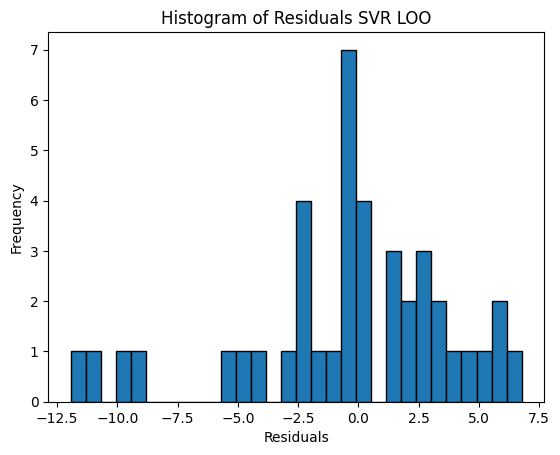

In [9]:
# Load the data
df = pd.read_csv('SVR_optimal_features_with_target.csv')  # Adjust the file name if needed

# Separate features and target variable
X = df.drop(['Lift-to-Place'], axis=1)
y = df['Lift-to-Place']

# Standardize features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Define a more extensive parameter grid for SVR
param_grid_svr = {
    'C': np.logspace(-4, 4, 10),  # Reduced granularity
    'epsilon': np.logspace(-4, 1, 6),  # Reduced granularity
    'kernel': ['linear', 'poly', 'rbf', 'sigmoid'],
    'degree': [2, 3, 4, 5],  # Reduced the range slightly
    'gamma': ['scale', 'auto'] + list(np.logspace(-4, 1, 6))  # Reduced granularity
}

# Initialize SVR model
svr = SVR()

# Initialize Leave-One-Out cross-validator
loo = LeaveOneOut()

# Perform Grid Search CV for hyperparameter tuning
print("*** Tuning hyperparameters for SVR (LOO)... ***")
grid_search_svr = GridSearchCV(svr, param_grid_svr, cv=loo, scoring='neg_mean_squared_error', n_jobs=-1, verbose=2)
grid_search_svr.fit(X_scaled, y)

# Best hyperparameters
best_params_svr = grid_search_svr.best_params_
print("Best parameters found:", best_params_svr)

# Train the SVR model with the best hyperparameters
svr_best = SVR(**best_params_svr)
svr_best.fit(X_scaled, y)

# Make predictions
y_pred_svr = svr_best.predict(X_scaled)

# Calculate RMSE
rmse_svr = np.sqrt(mean_squared_error(y, y_pred_svr))
print("Root Mean Squared Error (LOO SVR):", rmse_svr)

# Calculate residuals
residuals_svr = y - y_pred_svr

# Plot a histogram of the residuals
plt.hist(residuals_svr, bins=30, edgecolor='black')
plt.xlabel('Residuals')
plt.ylabel('Frequency')
plt.title('Histogram of Residuals SVR LOO')
plt.show()


In [10]:
# Load the data
df = pd.read_csv('SVR_optimal_features_with_target.csv')  # Adjust the file name if needed

# Separate features and target variable
X = df.drop(['Lift-to-Place'], axis=1)
y = df['Lift-to-Place']

# Standardize the features
scaler = StandardScaler()
X_combined_scaled = scaler.fit_transform(X)

# Define the optimal SVR model with the parameters obtained from grid search
svr_best = SVR(
    C=1291.5496650148827,        # Optimal C
    degree=2,         # Optimal degree (for polynomial kernel, though kernel is linear here)
    epsilon=0.1,      # Optimal epsilon
    gamma=0.01,    # Optimal gamma
    kernel='sigmoid'   # Optimal kernel
)

# Train the SVR model with the combined dataset
svr_best.fit(X_combined_scaled, y)

# Predict using the same combined dataset (since this is for training performance evaluation)
y_pred_combined = svr_best.predict(X_combined_scaled)

# Calculate RMSE for the combined dataset
rmse_combined = np.sqrt(mean_squared_error(y, y_pred_combined))
print("Root Mean Squared Error (RMSE) for Combined Data with Optimal SVR Parameters:", rmse_combined)


Root Mean Squared Error (RMSE) for Combined Data with Optimal SVR Parameters: 4.335166781407693


In [11]:
from IPython.core.display import HTML
# Create HTML for text with gradient color
html_text = """
<div style='font-size:50px; font-weight:bold; text-align:center; background: linear-gradient(to right, red, orange, yellow, green, blue, indigo, violet); -webkit-background-clip: text; color: transparent;'>
    SVR Approach 3 Testing all Population
</div>
"""

# Display the HTML in the output cell
display(HTML(html_text))

Root Mean Squared Error on Combined Testing Data (Optimized SVR): 3.1694169556951395


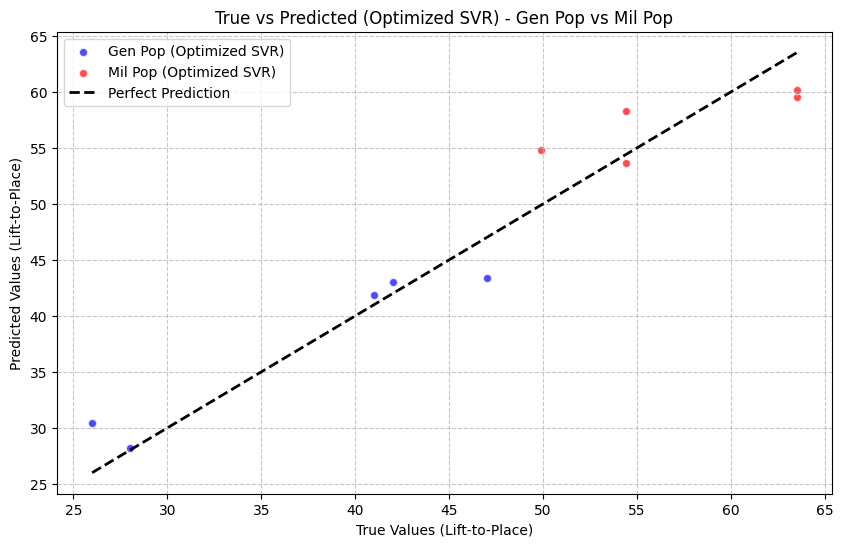

<Figure size 640x480 with 0 Axes>

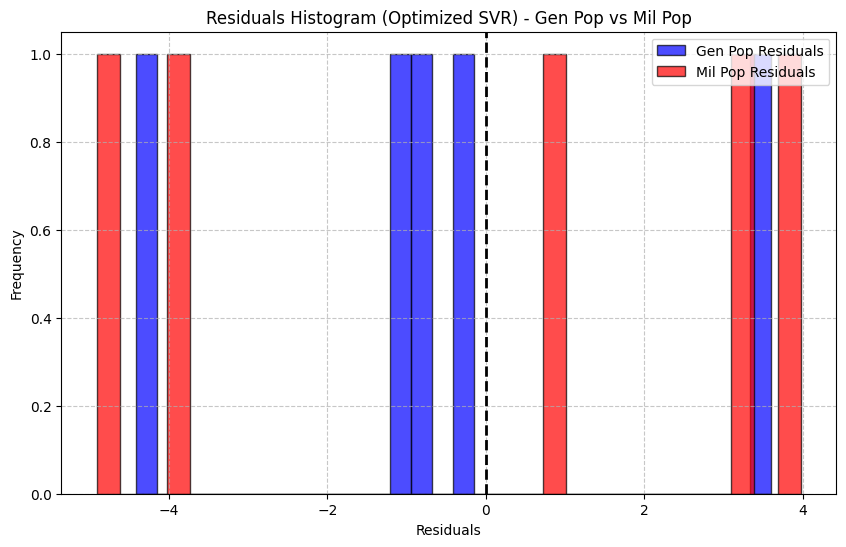

<Figure size 640x480 with 0 Axes>

In [12]:
import pandas as pd
import numpy as np
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt

# Load the testing datasets
df_testing_gen_pop = pd.read_csv('Testing_Set_Gen_Pop_No_MP.csv')  # Load General Population testing data
df_testing_mil_pop = pd.read_csv('Testing_Set_Mil_Pop_No_MP.csv')  # Load Military Population testing data

# Add a column to identify the population type
df_testing_gen_pop['Population'] = 'Gen_Pop'
df_testing_mil_pop['Population'] = 'Mil_Pop'

# Combine the General Population and Military Population test data
df_testing_combined = pd.concat([df_testing_gen_pop, df_testing_mil_pop], axis=0)

# Select the same columns as in the training dataset
X_testing = df_testing_combined[X.columns]  # Ensure the same columns are used as in training

# Standardize the features in the testing dataset using the same scaler used for the training data
X_testing_scaled = scaler.transform(X_testing)  # Use the scaler from training

### Optimized SVR Model Evaluation

# Use the best SVR model obtained from the RandomizedSearchCV
y_pred_testing_opt = svr_best.predict(X_testing_scaled)

# Add the predicted values to the testing dataset
df_testing_combined['Predicted_Weight_Lifted'] = y_pred_testing_opt

# Calculate RMSE for the combined testing data
true_y_testing = df_testing_combined['Lift-to-Place']
rmse_testing = np.sqrt(mean_squared_error(true_y_testing, y_pred_testing_opt))
print("Root Mean Squared Error on Combined Testing Data (Optimized SVR):", rmse_testing)

### Plot comparison of True vs Predicted (Optimized SVR)

# Create a plot to compare True vs Predicted values with different colors for Gen Pop and Mil Pop
plt.figure(figsize=(10, 6))

# Plot True vs Predicted for General Population (in blue)
gen_pop_mask = df_testing_combined['Population'] == 'Gen_Pop'
plt.scatter(
    df_testing_combined.loc[gen_pop_mask, 'Lift-to-Place'], 
    df_testing_combined.loc[gen_pop_mask, 'Predicted_Weight_Lifted'], 
    alpha=0.7, label='Gen Pop (Optimized SVR)', color='blue', edgecolors='w'
)

# Plot True vs Predicted for Military Population (in red)
mil_pop_mask = df_testing_combined['Population'] == 'Mil_Pop'
plt.scatter(
    df_testing_combined.loc[mil_pop_mask, 'Lift-to-Place'], 
    df_testing_combined.loc[mil_pop_mask, 'Predicted_Weight_Lifted'], 
    alpha=0.7, label='Mil Pop (Optimized SVR)', color='red', edgecolors='w'
)

# Plot Perfect Prediction Line
plt.plot([true_y_testing.min(), true_y_testing.max()], [true_y_testing.min(), true_y_testing.max()], 'k--', lw=2, label='Perfect Prediction')

# Plot styling
plt.title('True vs Predicted (Optimized SVR) - Gen Pop vs Mil Pop')
plt.xlabel('True Values (Lift-to-Place)')
plt.ylabel('Predicted Values (Lift-to-Place)')
plt.grid(True, linestyle='--', alpha=0.7)
plt.legend()

# Show the plot
plt.show()

### Save the predictions and plots to files

# Save combined testing dataset with all predictions
df_testing_combined.to_csv('Testing_Set_Predictions_SVR_Optimized_Combined.csv', index=False)

# Save the plot as an image file
plt.savefig('True_vs_Predicted_Plot_SVR_Optimized_Combined.png', format='png')

### Residual Plot for True vs Residuals (Optimized SVR)
### Residual Histogram for True vs Residuals (Optimized SVR) with Different Colors for Gen Pop and Mil Pop

# Calculate residuals
df_testing_combined['Residuals'] = df_testing_combined['Lift-to-Place'] - df_testing_combined['Predicted_Weight_Lifted']

# Create a residual histogram with different colors for Gen Pop and Mil Pop
plt.figure(figsize=(10, 6))

# Plot Residual Histogram for General Population (in blue)
plt.hist(
    df_testing_combined.loc[gen_pop_mask, 'Residuals'], 
    bins=30, alpha=0.7, label='Gen Pop Residuals', color='blue', edgecolor='black'
)

# Plot Residual Histogram for Military Population (in red)
plt.hist(
    df_testing_combined.loc[mil_pop_mask, 'Residuals'], 
    bins=30, alpha=0.7, label='Mil Pop Residuals', color='red', edgecolor='black'
)

# Plot styling
plt.axvline(0, color='black', linestyle='--', lw=2)  # Vertical line at 0 (perfect residual)
plt.title('Residuals Histogram (Optimized SVR) - Gen Pop vs Mil Pop')
plt.xlabel('Residuals')
plt.ylabel('Frequency')
plt.grid(True, linestyle='--', alpha=0.7)
plt.legend()

# Show the plot
plt.show()

### Save the residual histogram as an image file
plt.savefig('Residual_Histogram_SVR_Optimized_Combined.png', format='png')




In [13]:
from IPython.core.display import HTML
# Create HTML for text with gradient color
html_text = """
<div style='font-size:50px; font-weight:bold; text-align:center; background: linear-gradient(to right, red, orange, yellow, green, blue, indigo, violet); -webkit-background-clip: text; color: transparent;'>
    Mil Population
</div>
"""

# Display the HTML in the output cell
display(HTML(html_text))

Root Mean Squared Error on Testing Data (Optimized SVR): 3.636331371892465


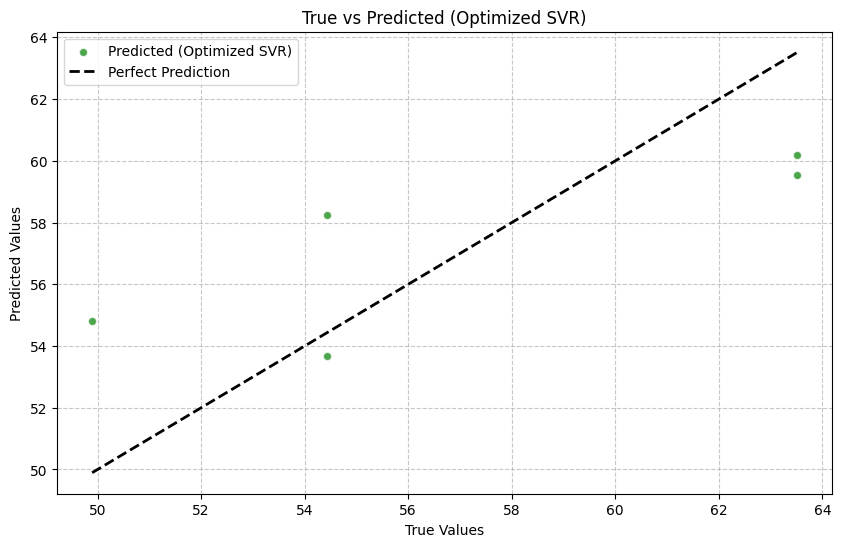

<Figure size 640x480 with 0 Axes>

In [14]:
import pandas as pd
import numpy as np
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt

# Load the testing dataset
df_testing = pd.read_csv('Testing_Set_Mil_Pop_No_MP.csv')

# Select the same columns as in the training dataset
X_testing = df_testing[X.columns]  # Ensure the same columns are used as in training

# Standardize the features in the testing dataset using the same scaler used for the training data
X_testing_scaled = scaler.transform(X_testing)  # Use the scaler from training

### Optimized SVR Model Evaluation

# Use the best SVR model obtained from the RandomizedSearchCV
y_pred_testing_opt = svr_best.predict(X_testing_scaled)

# Add the predicted values to the testing dataset
df_testing['Predicted_Weight_Lifted'] = y_pred_testing_opt

# Calculate RMSE for the testing data
true_y_testing = df_testing['Lift-to-Place']
rmse_testing = np.sqrt(mean_squared_error(true_y_testing, y_pred_testing_opt))
print("Root Mean Squared Error on Testing Data (Optimized SVR):", rmse_testing)

### Plot comparison of True vs Predicted (Optimized SVR)

# Create a plot to compare True vs Predicted values
plt.figure(figsize=(10, 6))

# Plot True vs Predicted (Optimized SVR)
plt.scatter(true_y_testing, y_pred_testing_opt, alpha=0.7, label='Predicted (Optimized SVR)', color='green', edgecolors='w')
plt.plot([true_y_testing.min(), true_y_testing.max()], [true_y_testing.min(), true_y_testing.max()], 'k--', lw=2, label='Perfect Prediction')
plt.title('True vs Predicted (Optimized SVR)')
plt.xlabel('True Values')
plt.ylabel('Predicted Values')
plt.grid(True, linestyle='--', alpha=0.7)
plt.legend()

# Show the plot
plt.show()

### Save the predictions and plots to files

# Save testing dataset with all predictions
df_testing.to_csv('Testing_Set_Predictions_SVR_Optimized_Mil_Pop.csv', index=False)

# Save the plot as an image file
plt.savefig('True_vs_Predicted_Plot_SVR_Optimized_Mil_Pop.png', format='png')


In [15]:
from IPython.core.display import HTML
# Create HTML for text with gradient color
html_text = """
<div style='font-size:50px; font-weight:bold; text-align:center; background: linear-gradient(to right, red, orange, yellow, green, blue, indigo, violet); -webkit-background-clip: text; color: transparent;'>
    Gen Population
</div>
"""

# Display the HTML in the output cell
display(HTML(html_text))

Root Mean Squared Error on Testing Data (Optimized SVR): 2.620591885793428


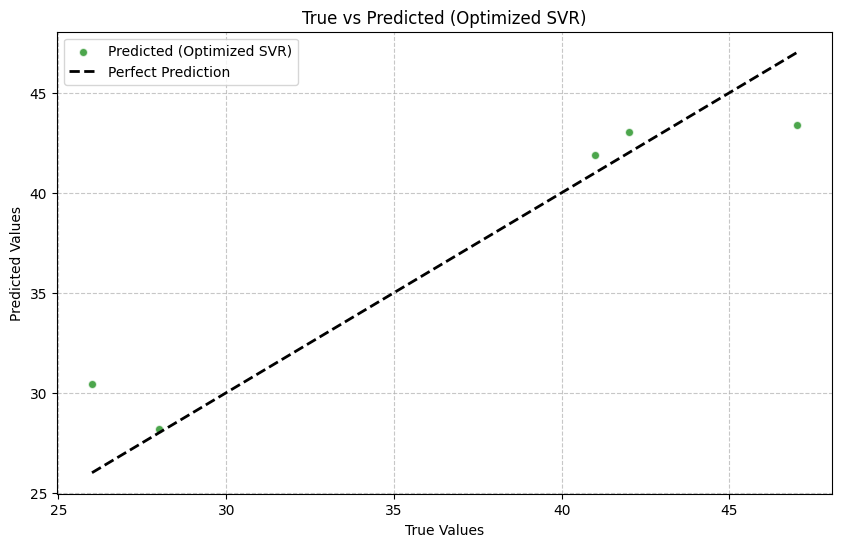

<Figure size 640x480 with 0 Axes>

In [16]:
import pandas as pd
import numpy as np
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt

# Load the testing dataset
df_testing = pd.read_csv('Testing_Set_Gen_Pop_No_MP.csv')

# Select the same columns as in the training dataset
X_testing = df_testing[X.columns]  # Ensure the same columns are used as in training

# Standardize the features in the testing dataset using the same scaler used for the training data
X_testing_scaled = scaler.transform(X_testing)  # Use the scaler from training

### Optimized SVR Model Evaluation

# Use the best SVR model obtained from the RandomizedSearchCV
y_pred_testing_opt = svr_best.predict(X_testing_scaled)

# Add the predicted values to the testing dataset
df_testing['Predicted_Weight_Lifted'] = y_pred_testing_opt

# Calculate RMSE for the testing data
true_y_testing = df_testing['Lift-to-Place']
rmse_testing = np.sqrt(mean_squared_error(true_y_testing, y_pred_testing_opt))
print("Root Mean Squared Error on Testing Data (Optimized SVR):", rmse_testing)

### Plot comparison of True vs Predicted (Optimized SVR)

# Create a plot to compare True vs Predicted values
plt.figure(figsize=(10, 6))

# Plot True vs Predicted (Optimized SVR)
plt.scatter(true_y_testing, y_pred_testing_opt, alpha=0.7, label='Predicted (Optimized SVR)', color='green', edgecolors='w')
plt.plot([true_y_testing.min(), true_y_testing.max()], [true_y_testing.min(), true_y_testing.max()], 'k--', lw=2, label='Perfect Prediction')
plt.title('True vs Predicted (Optimized SVR)')
plt.xlabel('True Values')
plt.ylabel('Predicted Values')
plt.grid(True, linestyle='--', alpha=0.7)
plt.legend()

# Show the plot
plt.show()

### Save the predictions and plots to files

# Save testing dataset with all predictions
df_testing.to_csv('Testing_Set_Predictions_SVR_Optimized_Gen_Pop.csv', index=False)

# Save the plot as an image file
plt.savefig('True_vs_Predicted_Plot_SVR_Optimized_Gen_Pop.png', format='png')


In [5]:
# Load the data
df = pd.read_csv('SVR_optimal_features_with_target.csv')  # Adjust the file name if needed

# Separate features and target variable
X = df.drop(['Lift-to-Place'], axis=1)
y = df['Lift-to-Place']

# Standardize the features
scaler = StandardScaler()
X_combined_scaled = scaler.fit_transform(X)

# Define the optimal SVR model with the parameters obtained from grid search
svr_best = SVR(
    C=1291.5496650148827,        # Optimal C
    degree=2,         # Optimal degree (for polynomial kernel, though kernel is linear here)
    epsilon=0.1,      # Optimal epsilon
    gamma=0.01,    # Optimal gamma
    kernel='sigmoid'   # Optimal kernel
)

# Train the SVR model with the combined dataset
svr_best.fit(X_combined_scaled, y)

# Predict using the same combined dataset (since this is for training performance evaluation)
y_pred_combined = svr_best.predict(X_combined_scaled)

# Calculate RMSE for the combined dataset
rmse_combined = np.sqrt(mean_squared_error(y, y_pred_combined))
print("Root Mean Squared Error (RMSE) for Combined Data with Optimal SVR Parameters:", rmse_combined)

Root Mean Squared Error (RMSE) for Combined Data with Optimal SVR Parameters: 4.335166781407693


Root Mean Squared Error on Combined Testing Data (Optimized SVR): 3.1694169556951395


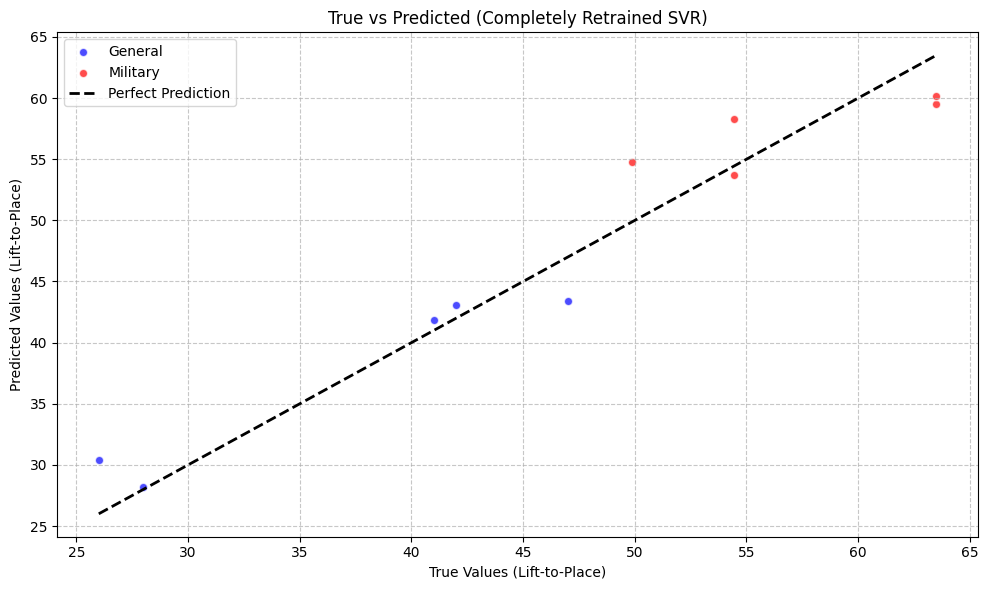

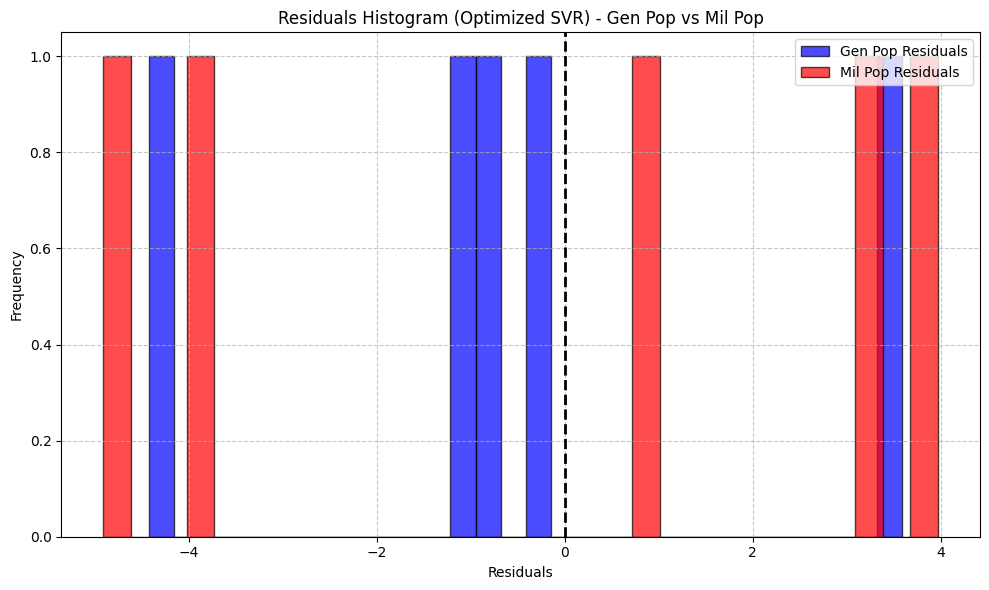

In [7]:
import pandas as pd
import numpy as np
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt

# Load the testing datasets
df_testing_gen_pop = pd.read_csv('Testing_Set_Gen_Pop_No_MP.csv')
df_testing_mil_pop = pd.read_csv('Testing_Set_Mil_Pop_No_MP.csv')

# Add a column to identify the population type
df_testing_gen_pop['Population'] = 'Gen_Pop'
df_testing_mil_pop['Population'] = 'Mil_Pop'

# Combine the datasets
df_testing_combined = pd.concat([df_testing_gen_pop, df_testing_mil_pop], axis=0)

# Select columns and scale (assumes `X` and `scaler` exist from training phase)
X_testing = df_testing_combined[X.columns]
X_testing_scaled = scaler.transform(X_testing)

# Predict using optimized SVR
y_pred_testing_opt = svr_best.predict(X_testing_scaled)
df_testing_combined['Predicted_Weight_Lifted'] = y_pred_testing_opt

# Calculate RMSE
true_y_testing = df_testing_combined['Lift-to-Place']
rmse_testing = np.sqrt(mean_squared_error(true_y_testing, y_pred_testing_opt))
print("Root Mean Squared Error on Combined Testing Data (Optimized SVR):", rmse_testing)

# Mask for group separation
gen_pop_mask = df_testing_combined['Population'] == 'Gen_Pop'
mil_pop_mask = df_testing_combined['Population'] == 'Mil_Pop'

### Plot: True vs Predicted and Save as TIFF (600 DPI)
plt.figure(figsize=(10, 6))
plt.scatter(
    df_testing_combined.loc[gen_pop_mask, 'Lift-to-Place'],
    df_testing_combined.loc[gen_pop_mask, 'Predicted_Weight_Lifted'],
    alpha=0.7, label='General', color='blue', edgecolors='w'
)
plt.scatter(
    df_testing_combined.loc[mil_pop_mask, 'Lift-to-Place'],
    df_testing_combined.loc[mil_pop_mask, 'Predicted_Weight_Lifted'],
    alpha=0.7, label='Military', color='red', edgecolors='w'
)
plt.plot(
    [true_y_testing.min(), true_y_testing.max()],
    [true_y_testing.min(), true_y_testing.max()],
    'k--', lw=2, label='Perfect Prediction'
)
plt.title('True vs Predicted (Completely Retrained SVR)')
plt.xlabel('True Values (Lift-to-Place)')
plt.ylabel('Predicted Values (Lift-to-Place)')
plt.grid(True, linestyle='--', alpha=0.7)
plt.legend()
plt.tight_layout()
plt.savefig('True_vs_Predicted_Plot_SVR_Optimized_Combined.tiff', format='tiff', dpi=600)
plt.show()

### Residual Histogram Plot and Save as TIFF (600 DPI)
df_testing_combined['Residuals'] = df_testing_combined['Lift-to-Place'] - df_testing_combined['Predicted_Weight_Lifted']

plt.figure(figsize=(10, 6))
plt.hist(
    df_testing_combined.loc[gen_pop_mask, 'Residuals'], 
    bins=30, alpha=0.7, label='Gen Pop Residuals', color='blue', edgecolor='black'
)
plt.hist(
    df_testing_combined.loc[mil_pop_mask, 'Residuals'], 
    bins=30, alpha=0.7, label='Mil Pop Residuals', color='red', edgecolor='black'
)
plt.axvline(0, color='black', linestyle='--', lw=2)
plt.title('Residuals Histogram (Optimized SVR) - Gen Pop vs Mil Pop')
plt.xlabel('Residuals')
plt.ylabel('Frequency')
plt.grid(True, linestyle='--', alpha=0.7)
plt.legend()
plt.tight_layout()
plt.savefig('Residual_Histogram_SVR_Optimized_Combined.tiff', format='tiff', dpi=600)
plt.show()

### Save predictions to CSV
df_testing_combined.to_csv('Testing_Set_Predictions_SVR_Optimized_Combined.csv', index=False)
